In [1]:
import pickle
import copy

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor

from keplergl import KeplerGl
from geopy.distance import geodesic as GD
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")



Essential functions

In [2]:
def setup_auxilary():
    auxilary_datasets = {}
    auxilary_datasets["existing_mrts"] = pd.read_csv("./datasets/auxiliary-data/sg-mrt-existing-stations.csv")
    auxilary_datasets["planned_mrts"] = pd.read_csv("./datasets/auxiliary-data/sg-mrt-planned-stations.csv")
    auxilary_datasets["primary_schools"] = pd.read_csv("./datasets/auxiliary-data/sg-primary-schools.csv")
    auxilary_datasets["shopping_malls"] = pd.read_csv("./datasets/auxiliary-data/sg-shopping-malls.csv")

    auxilary_datasets["cpi_housing"] = auxilary_datasets["cpi_housing"] = pd.read_csv("./datasets/auxiliary-data/singapore_cpi_housing.csv", header=9).iloc[:752, [0, 3]]
    auxilary_datasets["cpi_housing"].columns = ["month_year", "house_cpi"]
    auxilary_datasets["cpi_housing"] = auxilary_datasets["cpi_housing"][auxilary_datasets["cpi_housing"]["house_cpi"] != 'na']
    auxilary_datasets["cpi_housing"]['month_year'] = auxilary_datasets["cpi_housing"]['month_year'].apply(lambda x: x.strip())
    auxilary_datasets["cpi_housing"]['house_cpi'] = auxilary_datasets["cpi_housing"]['house_cpi'].astype(float)
    auxilary_datasets["cpi_housing_mapper"] = auxilary_datasets["cpi_housing"].set_index("month_year").to_dict()["house_cpi"]
    return(auxilary_datasets)

def train_test_spliter(df):
    train, valid = train_test_split(df, test_size=0.2)
    return(train, valid)

def fit_train_set(df):
    model_dict = {}
    model_dict["lr"] = LinearRegression().fit(df.loc[:,df.columns[:-1]], df.loc[:,df.columns[1]])
    model_dict['ada'] = AdaBoostClassifier().fit(df.loc[:,df.columns[:-1]], df.loc[:,df.columns[-1]])
    model_dict['rf'] = RandomForestRegressor().fit(df.loc[:,df.columns[:-1]], df.loc[:,df.columns[-1]])
    # eta=0.1, subsample=0.7, colsample_bytree=0.8 , n_estimators=100, learning_rate = 0.01
    # , n_estimators=150, learning_rate = 0.1, colsample_bytree=0.8, subsample=0.7
    model_dict['xg'] = XGBRegressor().fit(df.loc[:,df.columns[:-1]], df.loc[:,df.columns[-1]])
    return(model_dict)

def df_transformer(df, train, auxilary_datasets):

    df = df.reset_index(drop=True)

    # final columns to include in dataset
    numerical_cols_to_scale = [
        "floor_area_sqm",
        "closest_existing_mrt_dist",
        "remaining_lease_years_at_rent",
        "cpi",
        "latitude",
        "longitude",
        "distance_from_pioneer",
        "distance_from_rh",
        "distance_from_dg",
        "distance_from_sk",
        "distance_from_tam",
        "distance_from_amk",
        "nearest_Shopping",
        "nearest_Schools",
    ]
    cat_cols_to_encode = ["flat_type", "region"]
    target = "monthly_rent"

    df["rent_approval_date"] = pd.to_datetime(df["rent_approval_date"], format='%Y-%m')
    df["rent_approval_date_str"] = df["rent_approval_date"].dt.strftime(r'%Y %b')
    df["rent_approval_year_str"] = df["rent_approval_date"].dt.strftime(r'%Y')
    
    # data cleaning
    cols_to_encode = copy.deepcopy(cat_cols_to_encode)
    df[cols_to_encode] = df[cols_to_encode].apply(lambda x: x.str.lower())
    df[cols_to_encode] = df[cols_to_encode].apply(lambda x: x.str.replace(' ', '-'))

    # feature engineering of cpi column
    df["cpi"] = df["rent_approval_date_str"].map(auxilary_datasets["cpi_housing_mapper"])
    
    # feature engineering of remaining_lease_years_at_rent column
    df["lease_end_year"] = df["lease_commence_date"] + 99
    df["rent_start_year"] = df["rent_approval_date"].apply(lambda x: x.year)
    df["remaining_lease_years_at_rent"] = df["lease_end_year"] - df["rent_start_year"]
     
    if train:
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)        

        # one hot encoding for categorical attributes
        categorical_df = df[cat_cols_to_encode]
        enc = OneHotEncoder()
        one_hot = enc.fit_transform(categorical_df).toarray()
        with open("one_hot_encodings", "wb") as f:
            pickle.dump(enc, f)
            f.close()
        one_hot_with_cols = pd.DataFrame(data = one_hot, columns = enc.get_feature_names_out(categorical_df.columns))
            
    else:
        # load one hot encoder fit on training dataset
        with open("one_hot_encodings", "rb") as f:
            one_hot_encoder = pickle.load(f)
        
        categorical_df = df[cat_cols_to_encode]
        one_hot = one_hot_encoder.transform(categorical_df).toarray()
        one_hot_with_cols = pd.DataFrame(data = one_hot, columns = one_hot_encoder.get_feature_names_out(categorical_df.columns))

    if train:
        df = pd.concat([df[numerical_cols_to_scale].reset_index(drop=True), one_hot_with_cols.reset_index(drop=True), df[target].reset_index(drop=True)], axis=1)
    else:
        df = pd.concat([df[numerical_cols_to_scale].reset_index(drop=True), one_hot_with_cols], axis=1)
        
    return(df)


In [4]:
auxilary_datasets = setup_auxilary()

EDA/Data Visualization

In [5]:
train_df = pd.read_csv("./datasets/train_modified.csv")
train_df = df_transformer(train_df, True, auxilary_datasets)
map = KeplerGl(height=700, width=700)
mrt_data = pd.read_csv("./datasets/auxiliary-data/sg-mrt-existing-stations.csv")
map.add_data(data=train_df, name='houses')
map.add_data(data=mrt_data, name='mrts')
map

KeyError: "['distance_from_pioneer', 'distance_from_rh', 'distance_from_dg', 'distance_from_sk', 'distance_from_tam', 'distance_from_amk'] not in index"

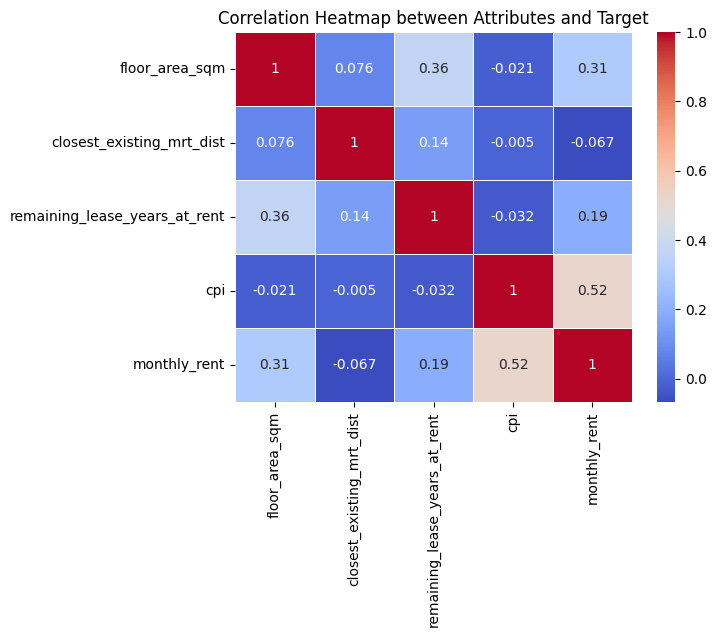

In [12]:
#looking at correlation
train_df_numerical = train_df[["floor_area_sqm", "closest_existing_mrt_dist", "remaining_lease_years_at_rent", "cpi", "monthly_rent"]]
train_df_numerical = train_df_numerical.select_dtypes(include=np.number)
corr_matrix = train_df_numerical.corr()
# Create a heatmap
# plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap between Attributes and Target")
plt.show()

Text(0, 0.5, 'CPI (Housing)')

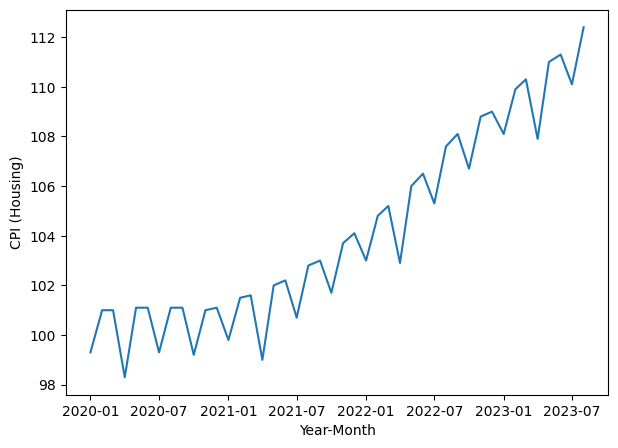

In [51]:
cpi = auxilary_datasets["cpi_housing"]
cpi["month_year"] = pd.to_datetime(auxilary_datasets["cpi_housing"]["month_year"], format='%Y %b')

interested_months = cpi[cpi["month_year"] >= "2020-01-01"]
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(interested_months["month_year"], interested_months["house_cpi"])
ax.set_xlabel("Year-Month")
ax.set_ylabel("CPI (Housing)")

In [17]:
df = pd.read_csv("./datasets/train_modified.csv")
existing_mrts = auxilary_datasets["existing_mrts"]

# selecting mrt station to represent the central business district and popular housing districts
dhoby = existing_mrts[existing_mrts["name"] == "Dhoby Ghaut"].reset_index(drop=True).iloc[0]
pioneer = existing_mrts[existing_mrts["name"] == "Pioneer"].reset_index(drop=True).iloc[0]
red_hill = existing_mrts[existing_mrts["name"] == "Redhill"].reset_index(drop=True).iloc[0]
sengkang = existing_mrts[existing_mrts["name"] == "Sengkang"].reset_index(drop=True).iloc[0]
tampines = existing_mrts[existing_mrts["name"] == "Tampines"].reset_index(drop=True).iloc[0]
amk = existing_mrts[existing_mrts["name"] == "Ang Mo Kio"].reset_index(drop=True).iloc[0]

# calculating the distance of each unit from popular housing districts and central business district
df["distance_from_pioneer"] = df.apply(lambda x: GD((pioneer.latitude, pioneer.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_rh"] = df.apply(lambda x: GD((red_hill.latitude, red_hill.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_dg"] = df.apply(lambda x: GD((dhoby.latitude, dhoby.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_sk"] = df.apply(lambda x: GD((sengkang.latitude, sengkang.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_tam"] = df.apply(lambda x: GD((tampines.latitude, tampines.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_amk"] = df.apply(lambda x: GD((amk.latitude, amk.longitude), (x.latitude, x.longitude)).km, axis=1)

df.to_csv("./datasets/train_final.csv", index=False)

In [18]:
df = pd.read_csv("./datasets/test_modified.csv")
existing_mrts = auxilary_datasets["existing_mrts"]

# selecting mrt station to represent the central business district and popular housing districts
dhoby = existing_mrts[existing_mrts["name"] == "Dhoby Ghaut"].reset_index(drop=True).iloc[0]
pioneer = existing_mrts[existing_mrts["name"] == "Pioneer"].reset_index(drop=True).iloc[0]
red_hill = existing_mrts[existing_mrts["name"] == "Redhill"].reset_index(drop=True).iloc[0]
sengkang = existing_mrts[existing_mrts["name"] == "Sengkang"].reset_index(drop=True).iloc[0]
tampines = existing_mrts[existing_mrts["name"] == "Tampines"].reset_index(drop=True).iloc[0]
amk = existing_mrts[existing_mrts["name"] == "Ang Mo Kio"].reset_index(drop=True).iloc[0]

# calculating the distance of each unit from popular housing districts and central business district
df["distance_from_pioneer"] = df.apply(lambda x: GD((pioneer.latitude, pioneer.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_rh"] = df.apply(lambda x: GD((red_hill.latitude, red_hill.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_dg"] = df.apply(lambda x: GD((dhoby.latitude, dhoby.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_sk"] = df.apply(lambda x: GD((sengkang.latitude, sengkang.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_tam"] = df.apply(lambda x: GD((tampines.latitude, tampines.longitude), (x.latitude, x.longitude)).km, axis=1)
df["distance_from_amk"] = df.apply(lambda x: GD((amk.latitude, amk.longitude), (x.latitude, x.longitude)).km, axis=1)

df.to_csv("./datasets/test_final.csv", index=False)

Model Selection

In [26]:
clean_train_df.columns

Index(['floor_area_sqm', 'closest_existing_mrt_dist',
       'remaining_lease_years_at_rent', 'cpi', 'latitude', 'longitude',
       'distance_from_pioneer', 'distance_from_rh', 'distance_from_dg',
       'distance_from_sk', 'distance_from_tam', 'distance_from_amk',
       'nearest_Shopping', 'nearest_Schools', 'flat_type_2-room',
       'flat_type_3-room', 'flat_type_4-room', 'flat_type_5-room',
       'flat_type_executive', 'region_central-region', 'region_east-region',
       'region_north-east-region', 'region_north-region', 'region_west-region',
       'monthly_rent'],
      dtype='object')

In [17]:
results = {
    "lr":[],
    "ada":[],
    "rf":[],
    "xg":[]
}

for i in range(10):
    train_df = pd.read_csv("./datasets/train_final.csv")
    train, valid = train_test_spliter(train_df)
    clean_train_df = df_transformer(train, True, auxilary_datasets)
    models = fit_train_set(clean_train_df)
    clean_valid_df = df_transformer(valid, False, auxilary_datasets)

    for model in models:
        valid_preds = models[model].predict(clean_valid_df)
        preds_df = pd.DataFrame(data = valid_preds, columns = ["Predicted"])
        results[model].append(mean_squared_error(valid["monthly_rent"], preds_df["Predicted"]))


In [18]:
results

{'lr': [7243685.618082804,
  7180018.7981989775,
  7229596.024170011,
  7188829.198136076,
  7254826.820952475,
  7177782.678544397,
  7298734.93535373,
  7205988.383469392,
  7212445.958990271,
  7295517.327571693],
 'ada': [833714.0046877615,
  539966.0974384731,
  465269.54629164573,
  576316.5494726268,
  710000.8371002846,
  425829.9849321949,
  502553.155868073,
  436434.5806127574,
  479664.9506110832,
  460875.3976226352],
 'rf': [282201.80067520525,
  284755.45676403417,
  279765.44557552354,
  281166.3527842966,
  281166.8413925027,
  281965.2694567983,
  279720.1904464856,
  285598.9306780734,
  278070.48425483203,
  280822.2299446162],
 'xg': [244808.77634824015,
  246342.72812565867,
  241341.7719114932,
  242716.94123488117,
  244934.50785692647,
  243793.16771906576,
  244182.4558603669,
  247645.2362555199,
  241761.96823874107,
  247478.29754436895]}

In [19]:
# determine model with best performance
for i, result in results.items():
    print(i, np.mean(result))

lr 7228742.574346982
ada 543062.5104637535
rf 281523.30019723676
xg 244500.58510952623
